In [2]:
import os
# import sys
# import gc
import numpy as np
# import numpy.ma as ma
import matplotlib.pyplot as plt
# from matplotlib.collections import PatchCollection
# from matplotlib import patches as mpatches
from matplotlib import colors
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
from scipy import interpolate
# from scipy.optimize import curve_fit
# from scipy.interpolate import interp1d
from astropy import wcs
from astropy.io import fits
# from astropy.nddata import Cutout2D
# from astropy.coordinates import SkyCoord
from astropy import units as u
# from astropy.table import Table
from astropy.wcs.utils import pixel_to_skycoord
from astropy.wcs.utils import skycoord_to_pixel
from reproject import reproject_interp
from lmfit import minimize, Parameters, Model
from spectral_cube import SpectralCube as sc
# from spectral_cube import Projection
# from fil_finder import FilFinder2D
# from fil_finder import pixel_ident as fpi
plt.interactive(True)
from matplotlib import rc
rc("font", family="serif", size=15)
rc("axes", linewidth=1)
rc("lines", linewidth=1)
rc("xtick.major", pad=5, width=1)
rc("ytick.major", pad=5, width=1)
rc("xtick.minor", width=1)
rc("ytick.minor", width=1)
rc('ytick', direction='in', labelsize=15)
rc('xtick', direction='in', labelsize=15)
rc('axes', labelsize=15)
mh = 1.67e-24; m0 = 1.67e-24*2.33; hp = 6.626e-27; kb = 1.38e-16; Gr = 6.67e-8;
pc = 3.086e18; au = 1.496e13; Jy = 1.0e-23;
c = 2.998e10; year = 86400.0*365;
Msun = 1.99e33; Lsun = 3.826e33; Rsun = 6.96e10; Tbg = 2.73; eV = 1.602e-12;
d2s=np.sqrt(8 * np.log(2))  # fwhm / std.
das = 390 * au       # 1 arcsec
ssb = 1.8047e-5      # Stefan-Boltzmann
r_cov = 3      # pixel numbers
def pv_cut(ix0, iy0, pa, ds, scu_data, vel_ax):
    s_arr = np.arange(-ds, ds, 0.1)
    nsr = len(s_arr)
    # nv = len(vel_ax)
    nv, ny, nx = np.shape(scu_data)
    pv_slice = np.zeros((nv, nsr))   # array to restore pv plot
    # Tb_near = scu_int[int(iy0)-ds_0:int(iy0)+ds_0+1, int(ix0):int(ix0)+ds_0+1]
    # [iy1, ix1] = np.where(Tb_near == Tb_near.max())
    # find the real maximum position:
    # iy0, ix0 = int(iy0) + (iy1[0] - ds_0), int(ix0) + (ix1[0] - ds_0)
    ix0, iy0 = int(ix0), int(iy0)
    for i in np.arange(nsr):
        weight_sum = 0
        # i-c along the slice:
        ixc, iyc = ix0-s_arr[i]*np.sin(pa), iy0+s_arr[i]*np.cos(pa)
        for j in np.arange(-2, 3):  # weighted average of the surrounding pixels
            for k in np.arange(-2, 3):
                ixs, iys = int(ixc)+j, int(iyc)+k
                rs = np.sqrt((ixs-ixc)**2+(iys-iyc)**2)
                weight = np.exp(-(rs)**2 / (2*r_cov**2))
                pv_slice[:, i] += weight * scu_data[:, iys, ixs]
                weight_sum += weight
        pv_slice[:, i] /= weight_sum
    return s_arr, pv_slice

def pv_plot(ix0, iy0, ds, pa, s_arr, vel_axis, pv_slice, scu_int, abox=[]):
    ny, nx = np.shape(scu_int)
    if abox==[]:
        abox=[0, nx, 0, ny]
    ps0 = [ix0 - (-ds*np.sin(pa)), iy0-ds*np.cos(pa)]
    ps1 = [ix0 + (-ds*np.sin(pa)), iy0+ds*np.cos(pa)]
    p_mesh, v_mesh = np.meshgrid(s_arr, vel_axis)
    vms = [scu_int.min(), scu_int.max()*0.9]
    lvs = scu_int.max()*np.arange(0.15, 1.1, 0.15)
    fig = plt.figure(figsize=(16, 7))  # figure window
    ax0 = fig.add_subplot(121)  # plot area with projection assigned
    # false-color image:
    sc0 = ax0.imshow(scu_int, origin='lower', aspect='equal', cmap='terrain_r',
                     vmin= vms[0], vmax=vms[1], alpha=0.7)
    ax0.plot([ps0[0], ps1[0]], [ps0[1], ps1[1]], c='black', linewidth=1)
    # contour levels:
    # ax0.contour(n2hp_int, levels=lvs, colors='white', origin='lower', linewidths=0.9)
    ax0.contour(scu_int, levels=lvs, colors='white', origin='lower', linewidths=0.9)
    ax0.set_xlabel('RA (pixel)')
    ax0.set_ylabel('Dec (pixel)')
    plt.colorbar(sc0)
    ax0.axis(abox)
    lvs = pv_slice.max()*np.arange(0.05, 1.1, 0.1)
    ax0 = fig.add_subplot(122)
    # ax0.imshow(pv_slice, origin='lower', aspect='auto')
    sc0 = ax0.pcolor(p_mesh, v_mesh, pv_slice, shading='auto')
    ax0.contour(p_mesh, v_mesh, pv_slice, levels=lvs, colors='white', origin='lower', linewidths=0.9)
    ax0.set_xlabel('Offset (pixel)')
    ax0.set_ylabel('Velocity (km/s)')
    plt.colorbar(sc0)
    plt.show()

[-1.93903277 19.0668806 ]


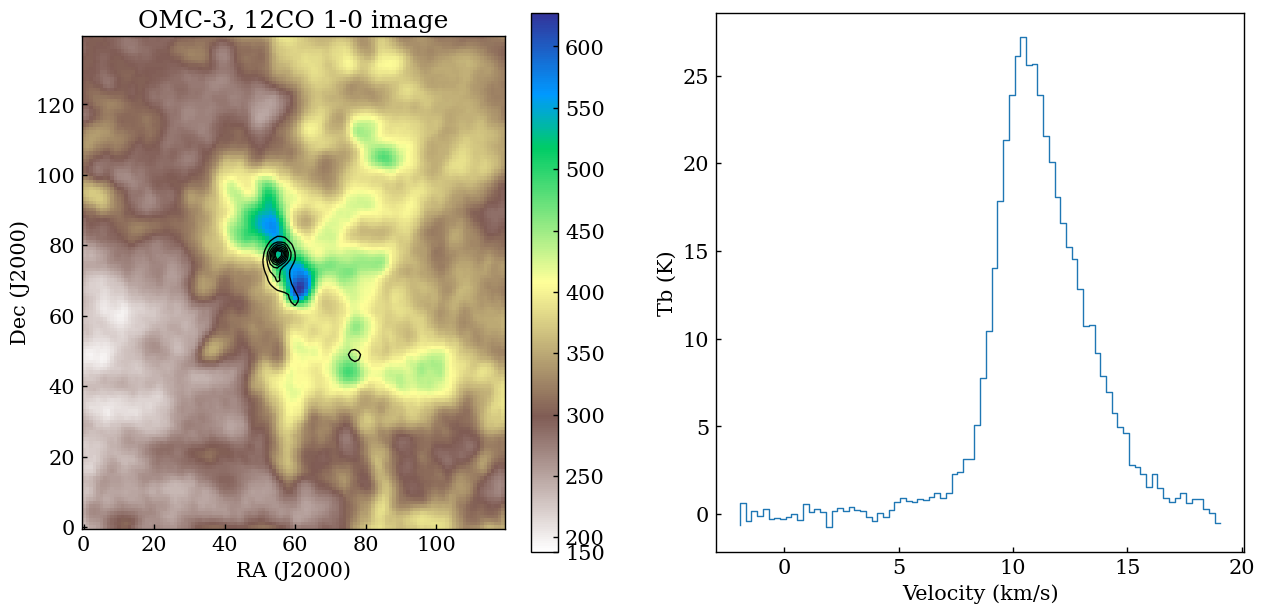

In [4]:
scu1 = sc.read('carma_omc23_12co_crop.fits')
v1_ax = scu1.spectral_axis.value/1000
scu1_data = scu1.hdu.data
print(v1_ax[[0,-1]])  # velocity range

w1 = wcs.WCS(scu1.header, naxis=2)
ny, nx = scu1.shape[1:3]
w1._naxis = [ny, nx]

hdu_70 = fits.open('pacs_70_rg.fits')
img_70 = hdu_70[0].data

#%% ---------------- data overview: int image and spectra------------------
# set position to inspect the line profile at different positions:
x_c,y_c = [60, 80]
# adjust to find the proper velocity range:
vrg = [0, 100]
im0 = np.sum(scu1_data[vrg[0]:vrg[1], :, :], axis=0)
vms0 = [im0.max()*0.3, im0.max()]
# norm0 = colors.LogNorm(vmin=vms_0[0], vmax=vms_0[1])
norm0 = colors.PowerNorm(1, vmin=vms0[0], vmax=vms0[1])

im1 = img_70
lvs = img_70.max() * np.arange(0.1, 0.9, 0.1)
# vms_1 = [img_1.max()*0.2, img_1.max()*0.9]

fg1 = plt.figure(figsize=(15,7))
ax0 = fg1.add_subplot(121)   # projection=w1 if RA-Dec

im_0 = ax0.imshow(im0, cmap='terrain_r', origin='lower', norm=norm0)
ax0.contour(im1, levels=lvs, colors='black', linewidths=1)
ax0.set_xlabel('RA (J2000)')
ax0.set_ylabel('Dec (J2000)')
ax0.set_title('OMC-3, 12CO 1-0 image')
cbar = plt.colorbar(im_0)

ax1 = fg1.add_subplot(122)
ax1.plot(v1_ax, scu1_data[:, y_c, x_c], drawstyle='steps') # set position to inspect the line profile at different positions.
ax1.set_xlabel('Velocity (km/s)')
ax1.set_ylabel('Tb (K)')
plt.show()

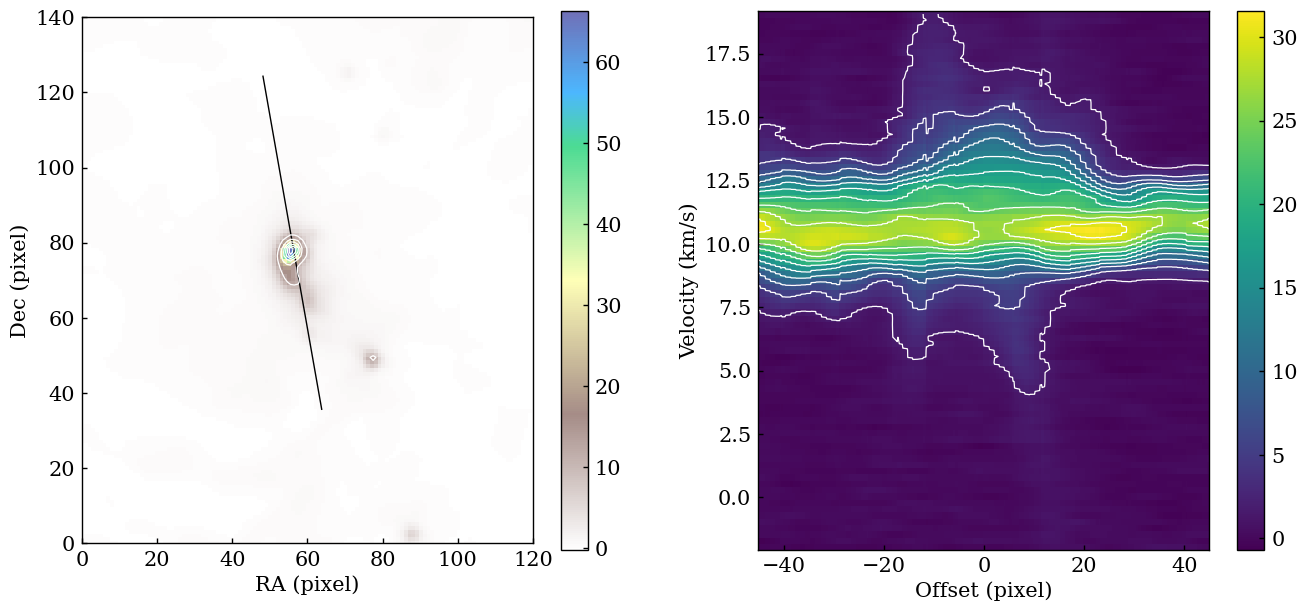

In [9]:
[ix0, iy0, pa0, ds0] = [56, 80, 10*np.pi/180, 45]

im1 = img_70
s_arr, pv_slice = pv_cut(ix0=ix0, iy0=iy0, pa=pa0, ds=ds0, scu_data=scu1_data, vel_ax=10)
pv_plot(ix0=ix0, iy0=iy0, ds=ds0, pa=pa0, s_arr=s_arr, vel_axis=v1_ax, pv_slice=pv_slice, scu_int=im1)

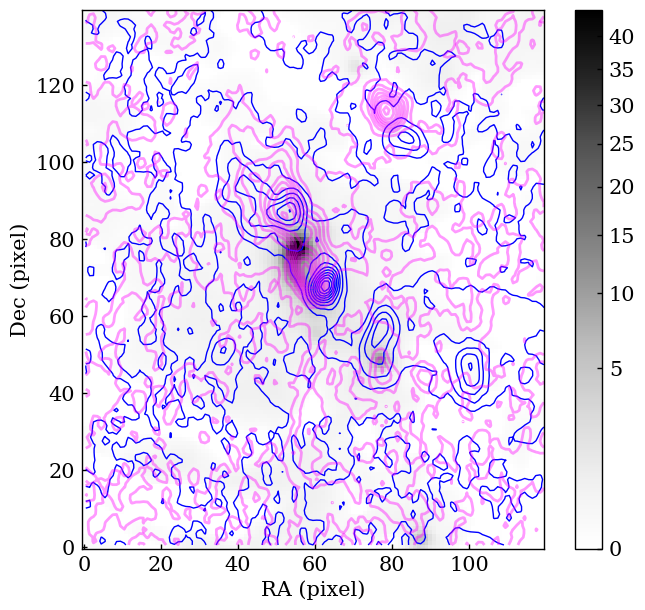

In [12]:
#%%--------- extract outflow lobes--------------------
scu_blue = scu1.spectral_slab(3 * u.km / u.s, 7.5 * u.km / u.s)  # determined from pv diagram and cross check
scu_red = scu1.spectral_slab(15 * u.km / u.s, 20 * u.km / u.s)  # fill the blank

img_blue = scu_blue.moment(order=0).value
img_red = scu_red.moment(order=0).value # fill the blank


#%% -------------outflow plot:------------------
im0 = img_70
vms = [0.03, im0.max()*0.6] # adjust to better exhibit the protostars (outflow center)
norm = colors.PowerNorm(0.5, vmin=vms[0], vmax=vms[1])

fig = plt.figure(figsize=(8, 7))  # figure window
ax0 = fig.add_subplot(111)

# false-color image:
sc0 = ax0.imshow(im0, origin='lower', aspect='equal', cmap='Greys',
                 norm=norm)
# contour levels:
# ax0.contour(scu_int, levels=lvs, colors='white', origin='lower', linewidths=0.9)

# arrange proper contour levels:
lvs0 = np.arange(0.01, 1, 0.1) * img_blue.max() # adjust to get clear contours
lvs1 = np.arange(0.01, 1, 0.1) * img_red.max()  # adjust to get clear contours

ax0.contour(img_blue, levels=lvs0, colors='blue', origin='lower', linewidths=1)
ax0.contour(img_red, levels=lvs1, colors='magenta', origin='lower', linewidths=2, alpha=0.4)
ax0.set_xlabel('RA (pixel)')
ax0.set_ylabel('Dec (pixel)')
# ax0.axis([?,?,?,?])  # adjust the box to center on different protostars
plt.colorbar(sc0)
plt.show()

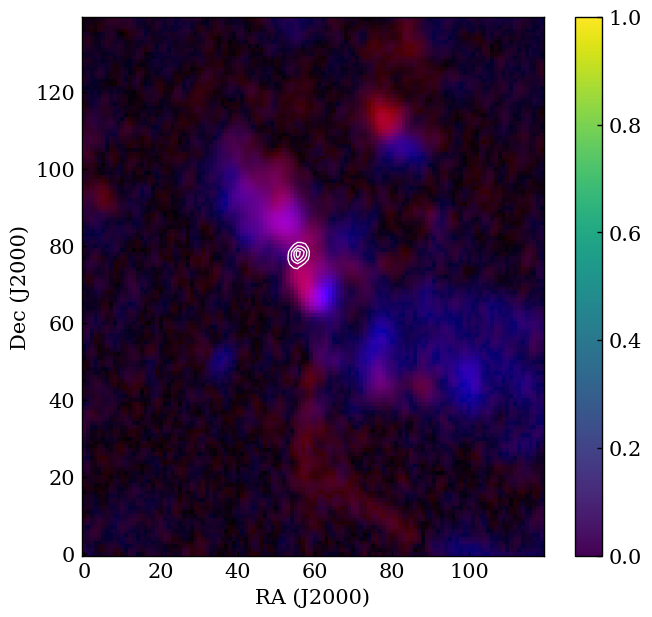

In [13]:
ny, nx = img_70.shape
img_rgb = np.zeros((ny, nx, 3))
img_rgb[:, :, 0] = img_red
img_rgb[:, :, 2] = img_blue
img_rgb = np.abs(img_rgb / img_rgb.max())
img_rgb = img_rgb ** 0.5

#%% RGB image for outflow plot:
im0 = img_rgb  # fill the blank
im1 = img_70

fig = plt.figure(figsize=(8, 7))  # figure window
ax0 = fig.add_subplot(111)  # plot area with projection assigned

# false-color image:
sc0 = ax0.imshow(im0, origin='lower', zorder=0)
# contour levels:
# ax0.contour(scu_int, levels=lvs, colors='white', origin='lower', linewidths=0.9)
lvs = np.arange(0.3, 1, 0.2) * im1.max()
ax0.contour(im1, levels=lvs, colors='white', origin='lower', linewidths=1)

# ax0.set_xlabel('RA (pixel)')
# ax0.set_ylabel('Dec (pixel)')

ax0.set_xlabel('RA (J2000)')
ax0.set_ylabel('Dec (J2000)')
# ax0.axis([20, 50, 20, 70])
plt.colorbar(sc0)
plt.show()

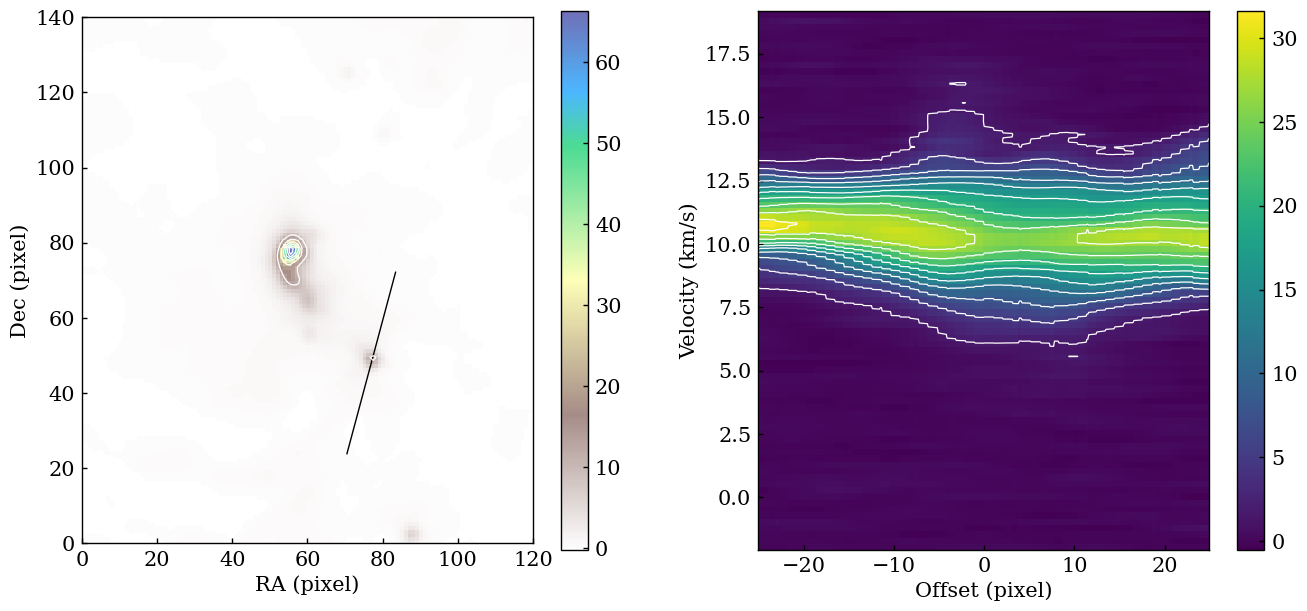

In [18]:
[ix0, iy0, pa0, ds0] = [77,48, -15*np.pi/180, 25]

im1 = img_70
s_arr, pv_slice = pv_cut(ix0=ix0, iy0=iy0, pa=pa0, ds=ds0, scu_data=scu1_data, vel_ax=10)
pv_plot(ix0=ix0, iy0=iy0, ds=ds0, pa=pa0, s_arr=s_arr, vel_axis=v1_ax, pv_slice=pv_slice, scu_int=im1)

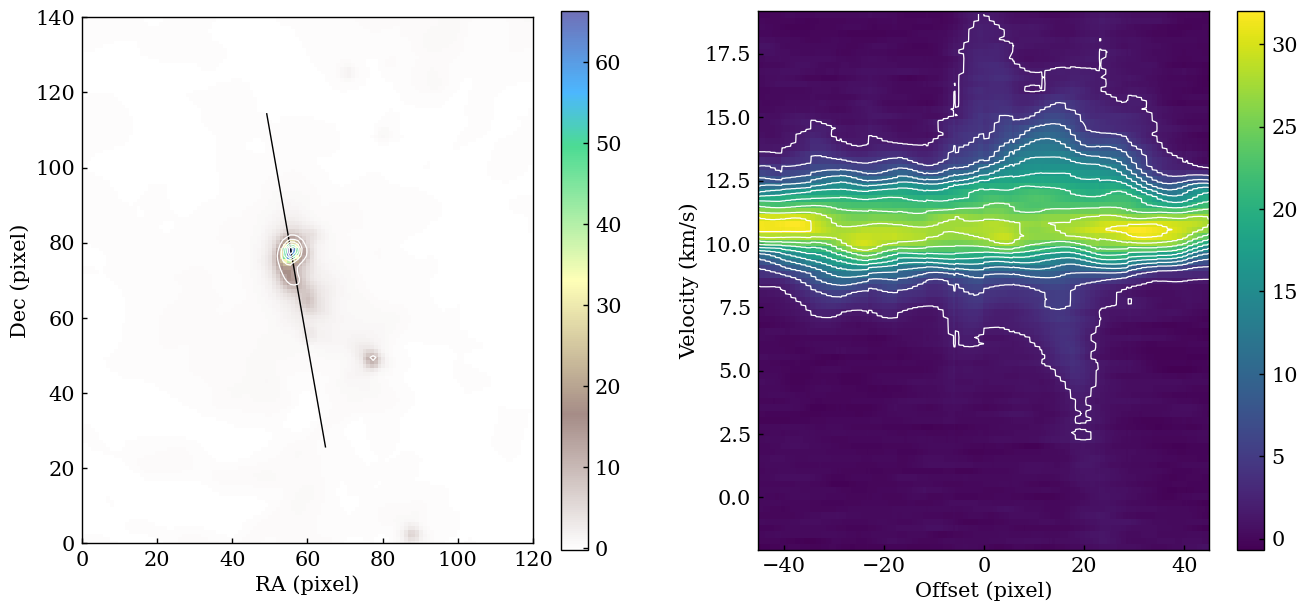

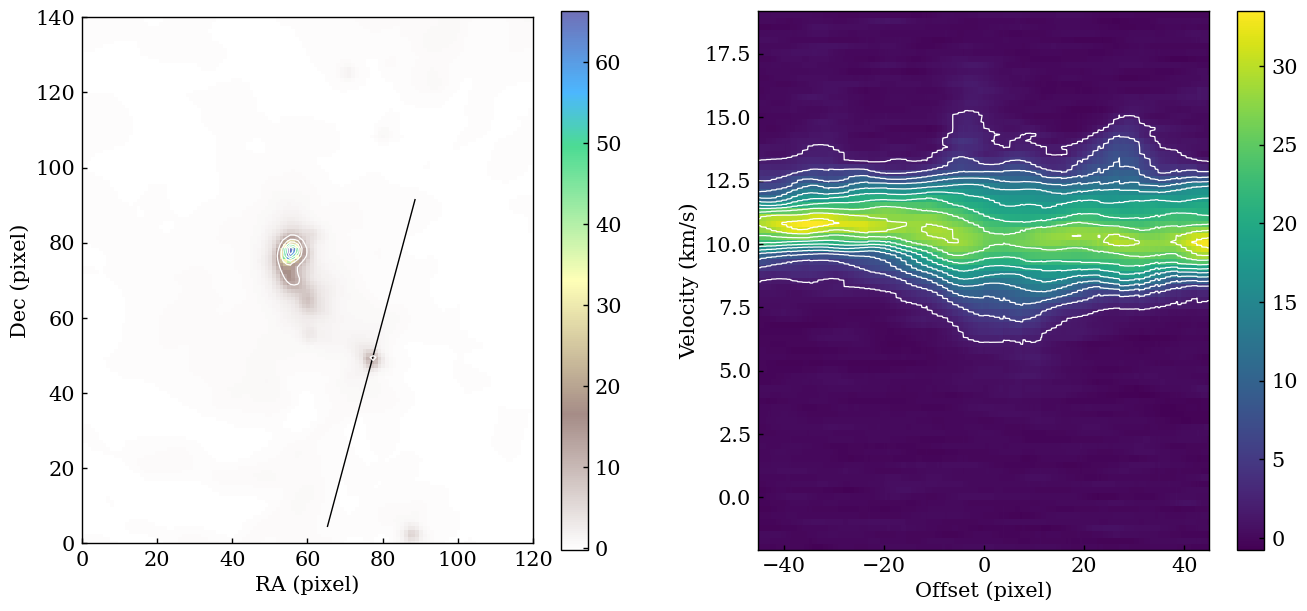

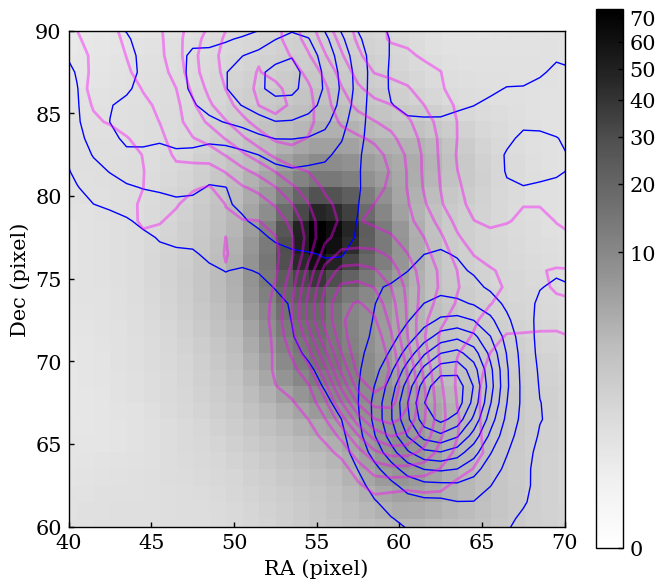

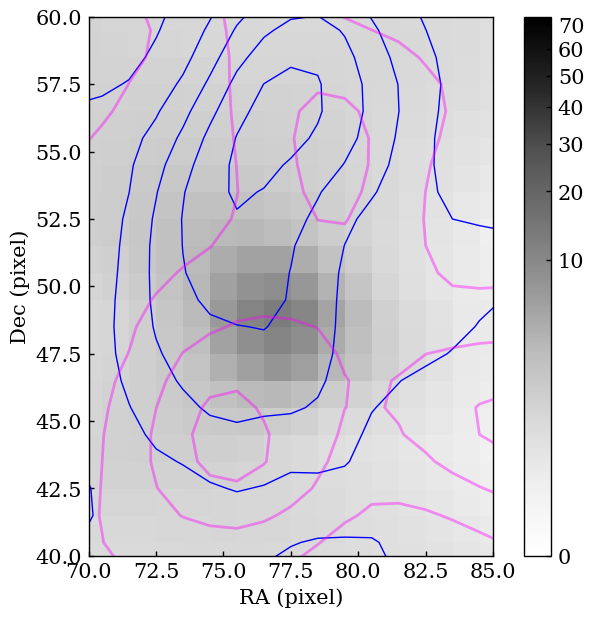

In [22]:
flow_pos = np.array([[57, 70, 10*np.pi/180, 45],       # outflow 1  : [x,y,pa(deg),ds(pixels)]
                    [77,48,-15*np.pi/180,45]])      # outflow 2

v_rg = np.array([[2.5,7.5,15,20],  # outflow 1: [v0_blue, v1_blue, v0_red, v1_red]
                 [5,7.5,12.5,15]])  # outflow 2: [v0_blue, v1_blue, v0_red, v1_red]

x_box = np.array([[40,70,60,90], # outflow 1: [x0_box, x1_box, y0_box, y0_box]
                  [70,85,40,60]])
vel_ax = v1_ax
im1 = img_70

for i in [0,1]:
    ix1, iy1, pa1, ds1 = flow_pos[i]
    s_arr, pv_slice = pv_cut(ix0=ix1, iy0=iy1, pa=pa1, ds=ds1, scu_data=scu1_data, vel_ax=vel_ax)
    pv_plot(ix0=ix1, iy0=iy1, ds=ds1, pa=pa1, s_arr=s_arr, vel_axis=v1_ax, pv_slice=pv_slice, scu_int=img_70)

#%% outflow lobes plot:
for i in [0,1]:
    ix1, iy1, pa1, ds1 = flow_pos[i]
    scu_blue = scu1.spectral_slab(v_rg[i,0] * u.km / u.s, v_rg[i,1] * u.km / u.s)  # determined from pv diagram and cross check
    scu_red = scu1.spectral_slab(v_rg[i,2] * u.km / u.s, v_rg[i,3] * u.km / u.s)
    img_blue = scu_blue.moment(order=0).value
    img_red = scu_red.moment(order=0).value
    im0 = img_70
    # vms = [im0.max()*0.1, im0.max()*0.9]
    vms = [0.01, im0.max()]
    # norm = colors.LogNorm(vmin=vms[0], vmax=vms[1])
    norm = colors.PowerNorm(0.3, vmin=vms[0], vmax=vms[1])
    fig = plt.figure(figsize=(8, 7))  # figure window
    ax0 = fig.add_subplot(111)
    # false-color image:
    sc0 = ax0.imshow(im0, origin='lower', aspect='equal', cmap='Greys',
                     norm=norm)
    lvs = np.arange(0.1, 1, 0.1) * img_blue.max()  # arrange proper contour levels
    ax0.contour(img_blue, levels=lvs, colors='blue', origin='lower', linewidths=1)
    lvs = np.arange(0.1, 1, 0.1) * img_red.max()
    ax0.contour(img_red, levels=lvs, colors='magenta', origin='lower', linewidths=2, alpha=0.4)
    ax0.set_xlabel('RA (pixel)')
    ax0.set_ylabel('Dec (pixel)')
    ax0.axis(x_box[i,:])  # adjust the box to focus on different cores.
    plt.colorbar(sc0)
    plt.show()

In [50]:
theta_lobe = 10*np.pi/180
dist = 390 * 3.08*10**18
m_co = 0.9 * 1.99*10**33
l_lobe =  theta_lobe * dist 
v_lobe = 20000  # km/s, typical outflow velocity, can be measured from PV diagram.
t_lobe = l_lobe/v_lobe
print('outflow age = ', t_lobe/31536000)
print('outflow mass rate=', np.log10(m_co/t_lobe *year/Msun))
print(pc)
print(Msun)
print(year)

outflow age =  332396229.30866134
outflow mass rate= -8.567413579079098
3.086e+18
1.99e+33
31536000.0


In [65]:
T_d = 28
r_c = l_lobe
L_c = ssb * T_d**4*r_c**2  # total luminosity
print('L/Lsun=', np.log10(L_c/Lsun))
print(Lsun)

L/Lsun= 8.105277560247309
3.826e+33


In [61]:
print((0.6*np.log(3.28*10**33))-np.log(1.99*10**33)+5.7+np.log(31536000))

-7.40291150444553


In [64]:
print(np.log(10))

2.302585092994046
